
## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [4]:
CFG = {
    'X_RANGE':7, # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'EPOCHS':50,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':128,
    'SEED':41
}

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [6]:
cd drive/MyDrive/Colab Notebooks/따릉이

/content/drive/MyDrive/Colab Notebooks/따릉이


In [7]:
train = pd.read_csv('./train.csv')

In [8]:
train.head()

일시    광진구   동대문구    성동구    중랑구
0  20180101  0.592  0.368  0.580  0.162
1  20180102  0.840  0.614  1.034  0.260
2  20180103  0.828  0.576  0.952  0.288
3  20180104  0.792  0.542  0.914  0.292
4  20180105  0.818  0.602  0.994  0.308

## Data Visualization

In [9]:
def get_view_df(df, target):
    viewd = df[['일시', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()
    print(target)
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.lineplot(x='index', y=target, data=viewd)
    plt.show()

광진구


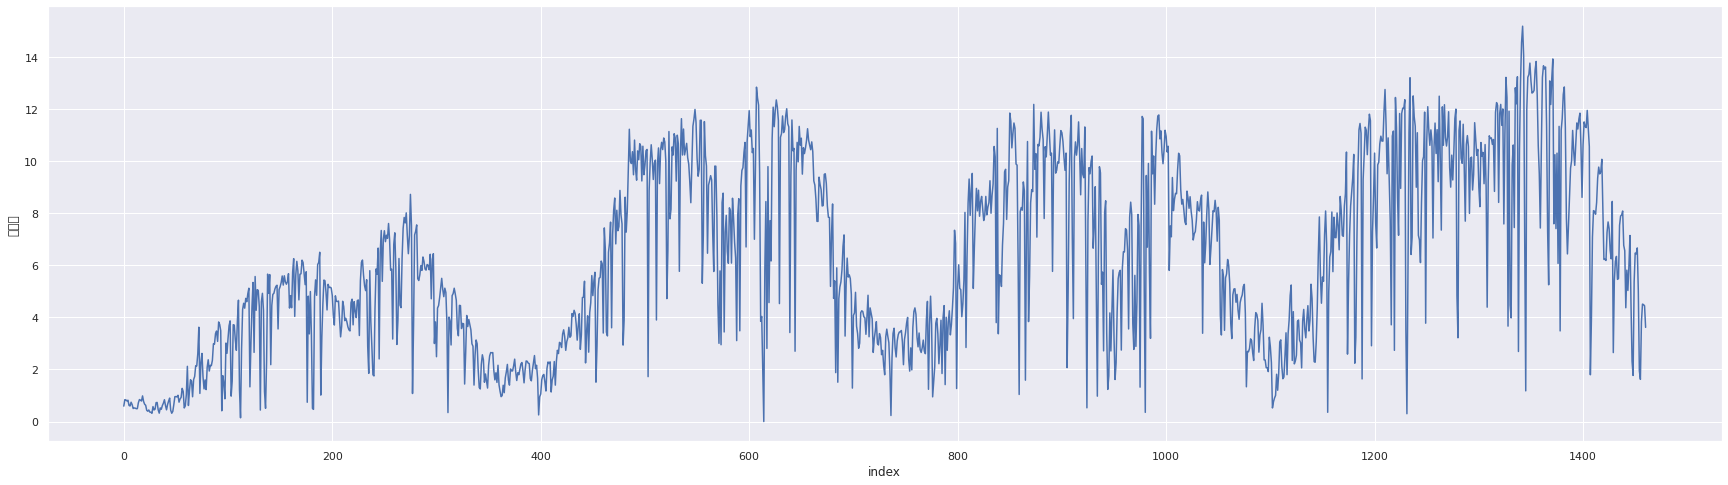

동대문구


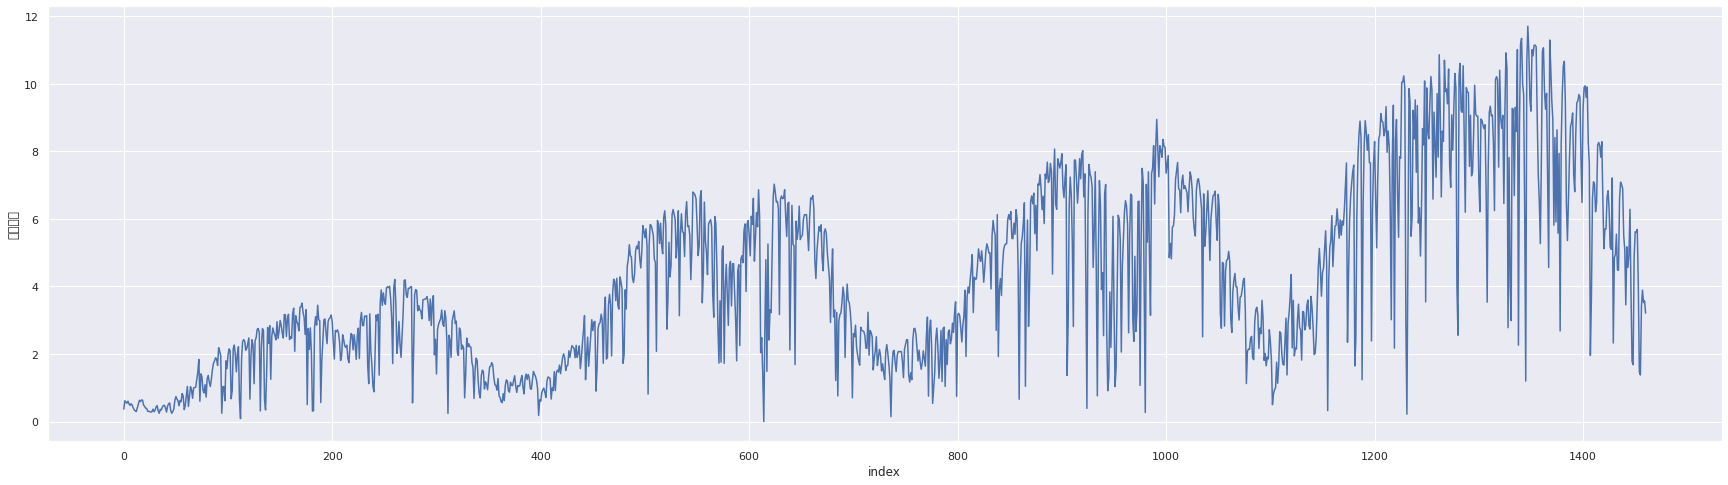

성동구


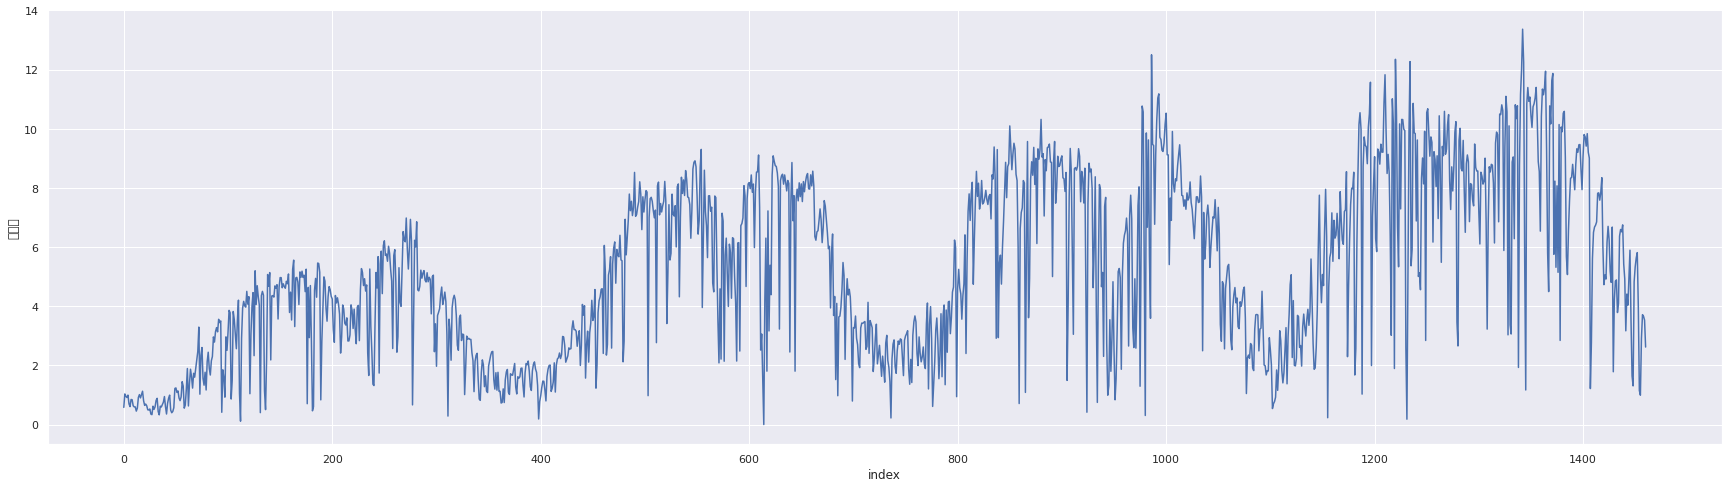

중랑구


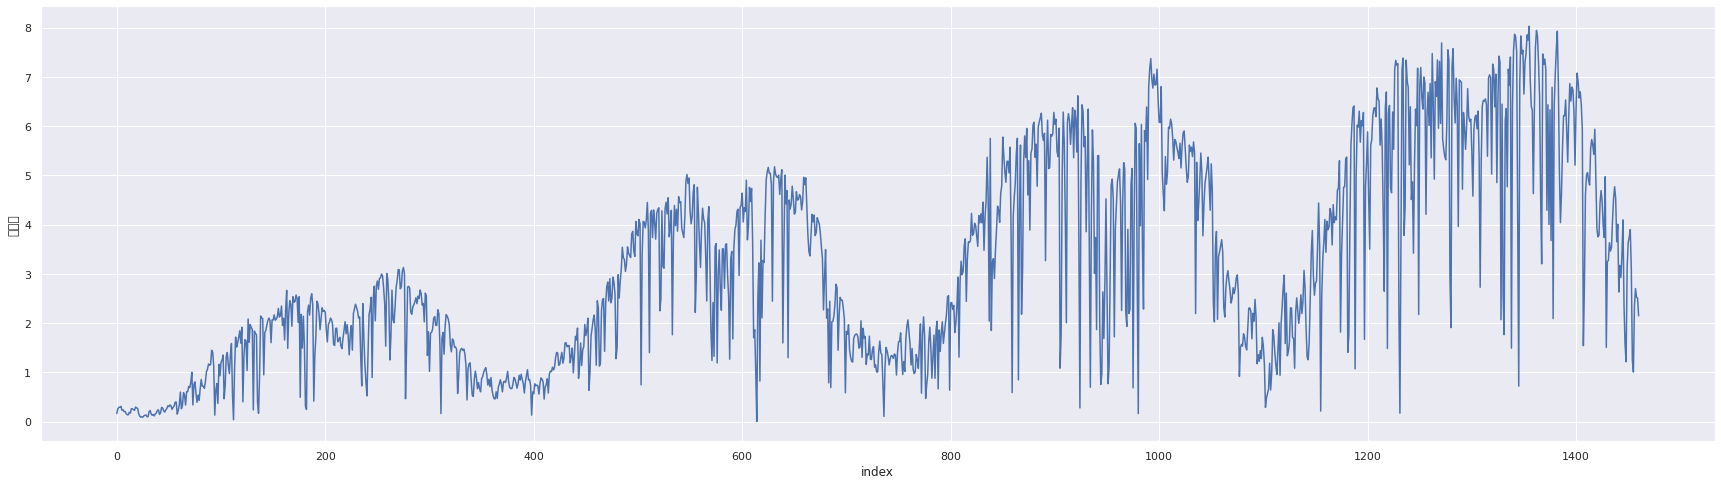

In [10]:
get_view_df(train, '광진구')
get_view_df(train, '동대문구')
get_view_df(train, '성동구')
get_view_df(train, '중랑구')

## Train / Validation Split

### 계절성 제거 후 추세성, 불규칙성, 순환성을 새로운 피처로 활용

In [11]:
from datetime import datetime

train['일시'] = train.일시.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
train.set_index('일시',inplace=True)

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

def func_diff(location,lamb):
    # 계절성 제거
    result = seasonal_decompose(train['{}'.format(location)], model='additive')
    result = result.observed
    
    # 추세 변동요인 추출 - trend
    cycle, trend = sm.tsa.filters.hpfilter(result,lamb)
    data_불규칙 = pd.DataFrame(cycle)

    # 불규칙 변동요인 제거한 순환변동요인 추출 - cycle2
    unrule, cycle2 = sm.tsa.filters.hpfilter(data_불규칙,lamb)

    # 표준화
    cycle_std = (cycle2-np.mean(cycle2))/np.std(cycle2)

    train['cycle_{}'.format(location)] = cycle_std
    train['unrule_{}'.format(location)] = unrule
    train['trend_{}'.format(location)] = trend

In [13]:
func_diff('광진구', 14400) #129600
func_diff('동대문구', 14400)
func_diff('성동구', 14400)
func_diff('중랑구', 14400)

In [14]:
train = train.reset_index()
train['일시'] = train['일시'].astype(str)

In [15]:
val_df = train.iloc[1096-CFG['X_RANGE']:].reset_index().drop(columns='index') # 20210101 ~ 20211231
# 위의 1096-CFG['X_RANGE']의 이유는 20210101을 예측하기 위해서는 이전 X_RANGE만큼의 일수가 필요하므로
train_df = train.iloc[:1096].reset_index().drop(columns='index') # 20180101 ~ 20201231

In [16]:
train_df

일시    광진구   동대문구    성동구    중랑구  cycle_광진구  unrule_광진구  \
0     2018-01-01  0.592  0.368  0.580  0.162   0.429076   -0.167658   
1     2018-01-02  0.840  0.614  1.034  0.260   0.411879    0.090705   
2     2018-01-03  0.828  0.576  0.952  0.288   0.394589    0.089087   
3     2018-01-04  0.792  0.542  0.914  0.292   0.377161    0.063492   
4     2018-01-05  0.818  0.602  0.994  0.308   0.359602    0.099909   
...          ...    ...    ...    ...    ...        ...         ...   
1091  2020-12-27  3.528  2.604  3.258  2.038  -0.229834    0.773564   
1092  2020-12-28  4.542  3.588  4.506  2.480  -0.282969    1.846816   
1093  2020-12-29  3.694  3.054  3.222  2.118  -0.343092    1.056764   
1094  2020-12-30  2.366  1.812  2.012  1.174  -0.408502   -0.215087   
1095  2020-12-31  2.366  2.018  1.988  1.358  -0.476907   -0.161375   

      trend_광진구  cycle_동대문구  unrule_동대문구  trend_동대문구  cycle_성동구  unrule_성동구  \
0      0.706571    0.446535    -0.176746    0.512872   0.497048   -0.289025   
1      0.698336    0.429486     0.076363    0.506980   0.476936    0.176143   
2      0.690093    0.412265     0.045494    0.501077   0.456640    0.105348   
3      0.681844    0.394774     0.018658    0.495163   0.436087    0.078597   
4      0.673600    0.376960     0.085854    0.489238   0.415271    0.169881   
...         ...         ...          ...         ...        ...         ...   
1091   2.782872   -0.588237     0.351152    2.294838  -0.100670    0.794072   
1092   2.730194   -0.626986     1.374379    2.258377  -0.153566    2.087234   
1093   2.679685   -0.672978     0.878140    2.223898  -0.215165    0.847652   
1094   2.631629   -0.724237    -0.327878    2.191576  -0.283263   -0.319199   
1095   2.586380   -0.777933    -0.088111    2.161641  -0.355115   -0.301962   

      trend_성동구  cycle_중랑구  unrule_중랑구  trend_중랑구  
0      0.815124   0.379444   -0.093799   0.234426  
1      0.806137   0.361588    0.008709   0.230924  
2      0.797134   0.343616    0.041229   0.227416  
3      0.788113   0.325423    0.049769   0.223901  
4      0.779086   0.306956    0.070331   0.220379  
...         ...        ...         ...        ...  
1091   2.474844  -0.427677    0.463564   1.598526  
1092   2.435419  -0.474435    0.937597   1.569127  
1093   2.397681  -0.530293    0.606667   1.541203  
1094   2.361917  -0.592982   -0.307502   1.514903  
1095   2.328471  -0.659488   -0.095265   1.490412  

[1096 rows x 17 columns]

## Data Pre-processing

In [17]:
def get_x_y_data_feature(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float))
        y_data.append(np.array(df.loc[i, ['cycle_광진구', 'unrule_광진구', 'trend_광진구','cycle_동대문구', 
                                          'unrule_동대문구', 'trend_동대문구', 'cycle_성동구', 'unrule_성동구',
                                    'trend_성동구', 'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [18]:
def make_ymd_feature_v1(df):
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[5:7].astype(int)/12.
    df['일'] = df['일시'].str[8:10].astype(int)/31.
    df = df.drop('일시',axis=1)
    return df

In [19]:
train_df = make_ymd_feature_v1(train_df)
val_df = make_ymd_feature_v1(val_df)

In [20]:
train_x_1, train_y_1 = get_x_y_data_feature(train_df)

  0%|          | 0/1089 [00:00<?, ?it/s]

In [21]:
val_x_1, val_y_1 = get_x_y_data_feature(val_df)

  0%|          | 0/365 [00:00<?, ?it/s]

In [22]:
train_x_1[0].shape, train_y_1[0].shape

((7, 19), (12,))

In [23]:
train_df.head(2)

광진구   동대문구    성동구    중랑구  cycle_광진구  unrule_광진구  trend_광진구  cycle_동대문구  \
0  0.592  0.368  0.580  0.162   0.429076   -0.167658   0.706571    0.446535   
1  0.840  0.614  1.034  0.260   0.411879    0.090705   0.698336    0.429486   

   unrule_동대문구  trend_동대문구  cycle_성동구  unrule_성동구  trend_성동구  cycle_중랑구  \
0    -0.176746    0.512872   0.497048   -0.289025   0.815124   0.379444   
1     0.076363    0.506980   0.476936    0.176143   0.806137   0.361588   

   unrule_중랑구  trend_중랑구      년         월         일  
0   -0.093799   0.234426  2.018  0.083333  0.032258  
1    0.008709   0.230924  2.018  0.083333  0.064516

## CustomDataset

In [24]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [25]:
train_dataset_1 = CustomDataset(train_x_1, train_y_1)
train_loader_1 = DataLoader(train_dataset_1, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset_1 = CustomDataset(val_x_1, val_y_1)
val_loader_1 = DataLoader(val_dataset_1, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Define Model

In [26]:
class BaseModel_feature(nn.Module):
    def __init__(self):
        super(BaseModel_feature, self).__init__()
        self.lstm = nn.LSTM(input_size=19, hidden_size=256, num_layers=1, batch_first=True)
        # input size = 데이터 열 갯수, num layer = ???
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=12),
            # out feature = 예측해야하는 지역 갯수
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:,-1,:])
        return output

## Train

In [27]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        val_mae = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val MAE : [{val_mae:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_mae)
            
        if best_loss > val_mae:
            best_loss = val_mae
            best_model = model 
    return best_model

In [28]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss    

## Run!!

In [29]:
model_feature = BaseModel_feature()

In [30]:
optimizer = torch.optim.Adam(params = model_feature.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4,threshold_mode='abs',min_lr=1e-8, verbose=True)
best_model = train(model_feature, optimizer, train_loader_1, val_loader_1, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [1.20286] Val MAE : [2.25448]
Epoch : [2] Train Loss : [0.62406] Val MAE : [3.33644]
Epoch : [3] Train Loss : [0.55847] Val MAE : [1.97062]
Epoch : [4] Train Loss : [0.51730] Val MAE : [1.63786]
Epoch : [5] Train Loss : [0.50660] Val MAE : [0.98737]
Epoch : [6] Train Loss : [0.49235] Val MAE : [0.81979]
Epoch : [7] Train Loss : [0.47281] Val MAE : [0.83859]
Epoch 00007: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [8] Train Loss : [0.44963] Val MAE : [0.75541]
Epoch : [9] Train Loss : [0.48644] Val MAE : [0.74837]
Epoch : [10] Train Loss : [0.42474] Val MAE : [0.67997]
Epoch : [11] Train Loss : [0.41744] Val MAE : [0.72232]
Epoch : [12] Train Loss : [0.41210] Val MAE : [0.64154]
Epoch 00012: reducing learning rate of group 0 to 2.5000e-03.
Epoch : [13] Train Loss : [0.38158] Val MAE : [0.63717]
Epoch : [14] Train Loss : [0.39539] Val MAE : [0.63932]
Epoch : [15] Train Loss : [0.37506] Val MAE : [0.62759]
Epoch : [16] Train Loss : [0.37281] Val MAE :

## Inference

In [31]:
def make_ymd_feature(df):
    df['일시'] = df['일시'].astype(str)
    df['년'] = df['일시'].str[:4].astype(int)/1000.
    df['월'] = df['일시'].str[4:6].astype(int)/12.
    df['일'] = df['일시'].str[6:8].astype(int)/31.
    df = df[['년', '월', '일', '광진구', '동대문구', '성동구', '중랑구']]
    return df

In [32]:
test_df = pd.read_csv('./sample_submission.csv')
test_df = make_ymd_feature(test_df)
test_df = pd.concat([val_df[CFG['X_RANGE']*(-1):], test_df]).reset_index().drop(columns='index')
test_df.fillna(0, inplace=True)

In [33]:
test_df # lambda 14400

광진구   동대문구    성동구    중랑구  cycle_광진구  unrule_광진구  trend_광진구  cycle_동대문구  \
0    1.946  1.474  1.148  1.246  -0.081750   -2.383935   4.340050   -0.311213   
1    1.620  1.378  0.992  1.004  -0.093048   -2.604659   4.236171   -0.352149   
2    3.830  3.416  2.908  2.350  -0.101798   -0.289997   4.132592   -0.389631   
3    4.510  3.890  3.714  2.700  -0.108748    0.494229   4.029226   -0.424748   
4    4.490  3.524  3.660  2.524  -0.114807    0.578241   3.925964   -0.458653   
..     ...    ...    ...    ...        ...         ...        ...         ...   
336  0.000  0.000  0.000  0.000   0.000000    0.000000   0.000000    0.000000   
337  0.000  0.000  0.000  0.000   0.000000    0.000000   0.000000    0.000000   
338  0.000  0.000  0.000  0.000   0.000000    0.000000   0.000000    0.000000   
339  0.000  0.000  0.000  0.000   0.000000    0.000000   0.000000    0.000000   
340  0.000  0.000  0.000  0.000   0.000000    0.000000   0.000000    0.000000   

     unrule_동대문구  trend_동대문구  cycle_성동구  unrule_성동구  trend_성동구  cycle_중랑구  \
0      -2.197064    3.693279   0.030141   -2.313147   3.457879   0.002368   
1      -2.199578    3.602715   0.017662   -2.383297   3.373382   0.020844   
2      -0.068549    3.512362   0.006846   -0.381806   3.289063   0.042131   
3       0.498166    3.422153  -0.002842    0.509443   3.204865   0.065288   
4       0.224723    3.332016  -0.012180    0.540617   3.120704   0.089298   
..           ...         ...        ...         ...        ...        ...   
336     0.000000    0.000000   0.000000    0.000000   0.000000   0.000000   
337     0.000000    0.000000   0.000000    0.000000   0.000000   0.000000   
338     0.000000    0.000000   0.000000    0.000000   0.000000   0.000000   
339     0.000000    0.000000   0.000000    0.000000   0.000000   0.000000   
340     0.000000    0.000000   0.000000    0.000000   0.000000   0.000000   

     unrule_중랑구  trend_중랑구      년         월         일  
0     -1.284133   2.530000  2.021  1.000000  0.806452  
1     -1.466341   2.469167  2.021  1.000000  0.838710  
2     -0.060873   2.408499  2.021  1.000000  0.870968  
3      0.348381   2.347941  2.021  1.000000  0.903226  
4      0.231536   2.287434  2.021  1.000000  0.935484  
..          ...        ...    ...       ...       ...  
336    0.000000   0.000000  2.022  0.916667  0.838710  
337    0.000000   0.000000  2.022  0.916667  0.870968  
338    0.000000   0.000000  2.022  0.916667  0.903226  
339    0.000000   0.000000  2.022  0.916667  0.935484  
340    0.000000   0.000000  2.022  0.916667  0.967742  

[341 rows x 19 columns]

In [34]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['cycle_광진구', 'unrule_광진구', 'trend_광진구','cycle_동대문구', 
                                          'unrule_동대문구', 'trend_동대문구', 'cycle_성동구', 'unrule_성동구',
                                    'trend_성동구', 'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구']] = model_pred
                                    
    return df.loc[CFG['X_RANGE']:, ['cycle_광진구', 'unrule_광진구', 'trend_광진구','cycle_동대문구', 
                                          'unrule_동대문구', 'trend_동대문구', 'cycle_성동구', 'unrule_성동구',
                                    'trend_성동구', 'cycle_중랑구', 'unrule_중랑구', 'trend_중랑구']].reset_index().drop(columns=['index'])

In [35]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

In [36]:
def get_x_y_data(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []
    y_data = []
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float))
        y_data.append(np.array(df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']]).astype(float))
    if infer:
        return x_data
    else:
        return x_data, y_data

In [37]:
train_x, train_y = get_x_y_data(train_df)
val_x, val_y = get_x_y_data(val_df)

  0%|          | 0/1089 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

In [38]:
train_x[0].shape, train_y[0].shape

((7, 19), (4,))

In [39]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [40]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=19, hidden_size=256, num_layers=4, batch_first=True)
        # input size = 데이터 열 갯수, num layer = ???
        
        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256, out_features=128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
                        
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(in_features=64, out_features=32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(in_features=32, out_features=16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(in_features=16, out_features=4),
            # out feature = 예측해야하는 지역 갯수
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.multioutput_reg(hidden[:,-1,:])
        return output

In [41]:
model = BaseModel()

In [42]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4,threshold_mode='abs',min_lr=1e-8, verbose=True)
best_model = train(model, optimizer, train_loader, val_loader, scheduler, device) # 2018.01.01 ~ 2020.12.31 까지 데이터로 학습

Epoch : [1] Train Loss : [3.83591] Val MAE : [6.16288]
Epoch : [2] Train Loss : [2.99663] Val MAE : [3.86462]
Epoch : [3] Train Loss : [2.07441] Val MAE : [2.36890]
Epoch : [4] Train Loss : [1.65335] Val MAE : [4.36902]
Epoch : [5] Train Loss : [1.50290] Val MAE : [3.17072]
Epoch : [6] Train Loss : [0.92023] Val MAE : [2.70163]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-03.
Epoch : [7] Train Loss : [0.88886] Val MAE : [3.14047]
Epoch : [8] Train Loss : [0.83498] Val MAE : [3.13094]
Epoch : [9] Train Loss : [0.82453] Val MAE : [3.15658]
Epoch : [10] Train Loss : [0.82227] Val MAE : [3.29054]
Epoch : [11] Train Loss : [0.84184] Val MAE : [3.27963]
Epoch 00011: reducing learning rate of group 0 to 2.5000e-03.
Epoch : [12] Train Loss : [0.81812] Val MAE : [3.11843]
Epoch : [13] Train Loss : [0.79707] Val MAE : [2.78222]
Epoch : [14] Train Loss : [0.79365] Val MAE : [3.25201]
Epoch : [15] Train Loss : [0.81689] Val MAE : [2.58507]
Epoch : [16] Train Loss : [0.80310] Val MAE :

In [43]:
test_df

광진구   동대문구    성동구    중랑구  cycle_광진구  unrule_광진구  trend_광진구  cycle_동대문구  \
0    1.946  1.474  1.148  1.246  -0.081750   -2.383935   4.340050   -0.311213   
1    1.620  1.378  0.992  1.004  -0.093048   -2.604659   4.236171   -0.352149   
2    3.830  3.416  2.908  2.350  -0.101798   -0.289997   4.132592   -0.389631   
3    4.510  3.890  3.714  2.700  -0.108748    0.494229   4.029226   -0.424748   
4    4.490  3.524  3.660  2.524  -0.114807    0.578241   3.925964   -0.458653   
..     ...    ...    ...    ...        ...         ...        ...         ...   
336  0.000  0.000  0.000  0.000  -3.667424   -0.152911   3.847183   -2.858826   
337  0.000  0.000  0.000  0.000  -3.666671   -0.152785   3.846635   -2.858329   
338  0.000  0.000  0.000  0.000  -3.665949   -0.152662   3.846116   -2.857852   
339  0.000  0.000  0.000  0.000  -3.665241   -0.152537   3.845611   -2.857386   
340  0.000  0.000  0.000  0.000  -3.664539   -0.152411   3.845110   -2.856926   

     unrule_동대문구  trend_동대문구  cycle_성동구  unrule_성동구  trend_성동구  cycle_중랑구  \
0      -2.197064    3.693279   0.030141   -2.313147   3.457879   0.002368   
1      -2.199578    3.602715   0.017662   -2.383297   3.373382   0.020844   
2      -0.068549    3.512362   0.006846   -0.381806   3.289063   0.042131   
3       0.498166    3.422153  -0.002842    0.509443   3.204865   0.065288   
4       0.224723    3.332016  -0.012180    0.540617   3.120704   0.089298   
..           ...         ...        ...         ...        ...        ...   
336    -0.166956    3.322421  -3.680578   -0.262325   3.549803  -3.018265   
337    -0.166714    3.321925  -3.679855   -0.262020   3.549466  -3.017759   
338    -0.166477    3.321455  -3.679163   -0.261724   3.549157  -3.017272   
339    -0.166238    3.320998  -3.678484   -0.261428   3.548860  -3.016795   
340    -0.165999    3.320546  -3.677813   -0.261132   3.548567  -3.016324   

     unrule_중랑구  trend_중랑구      년         월         일  
0     -1.284133   2.530000  2.021  1.000000  0.806452  
1     -1.466341   2.469167  2.021  1.000000  0.838710  
2     -0.060873   2.408499  2.021  1.000000  0.870968  
3      0.348381   2.347941  2.021  1.000000  0.903226  
4      0.231536   2.287434  2.021  1.000000  0.935484  
..          ...        ...    ...       ...       ...  
336    0.139004   2.575504  2.022  0.916667  0.838710  
337    0.139054   2.574939  2.022  0.916667  0.870968  
338    0.139104   2.574400  2.022  0.916667  0.903226  
339    0.139156   2.573872  2.022  0.916667  0.935484  
340    0.139210   2.573347  2.022  0.916667  0.967742  

[341 rows x 19 columns]

In [44]:
def inference(model, df, device):
    model.to(device)
    model.eval()
    for i in tqdm(range(CFG['X_RANGE'], len(df))):
        X = torch.Tensor(np.array(df.loc[i-CFG['X_RANGE']:i-1, train_df.columns]).astype(float)).unsqueeze(0)
        X = X.to(device)
        with torch.no_grad():
            model_pred = model(X)[0]
        
        model_pred = model_pred.cpu().numpy()
        df.loc[i, ['광진구', '동대문구', '성동구', '중랑구']] = model_pred
    return df.loc[CFG['X_RANGE']:, ['광진구', '동대문구', '성동구', '중랑구']].reset_index().drop(columns=['index'])

In [45]:
preds = inference(best_model, test_df, device)

  0%|          | 0/334 [00:00<?, ?it/s]

In [46]:
preds

광진구      동대문구       성동구       중랑구
0    3.708525  2.312281  3.232989  1.556260
1    4.065748  2.517007  3.546572  1.697538
2    3.385626  2.133511  2.844244  1.511142
3    2.576454  1.514009  2.107931  1.080529
4    2.179635  1.320736  1.780542  0.899656
..        ...       ...       ...       ...
329  4.089691  2.529696  3.567273  1.703362
330  4.087186  2.528239  3.565100  1.702428
331  4.084010  2.526389  3.562343  1.701233
332  4.080799  2.524519  3.559553  1.700029
333  4.077545  2.522626  3.556730  1.698811

[334 rows x 4 columns]

## Submission

In [47]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

일시  광진구  동대문구  성동구  중랑구
0  20220101    0     0    0    0
1  20220102    0     0    0    0
2  20220103    0     0    0    0
3  20220104    0     0    0    0
4  20220105    0     0    0    0

In [48]:
submit['광진구'] = preds['광진구'].round(3)
submit['동대문구'] = preds['동대문구'].round(3)
submit['성동구'] = preds['성동구'].round(3)
submit['중랑구'] = preds['중랑구'].round(3)

In [49]:
submit.to_csv('./submit.csv', index=False)